# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import sys
sys.path.append("/home/depend/workspace/MPSC_Guided_Imitation_Learning/ilqr/")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.cartpole import CartpoleDynamics

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.05
pole_length = 1.0
dynamics = CartpoleDynamics(dt, l=pole_length)

In [7]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0, 0.0, 0.0]))

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[0, 0] = 1.0
Q[1, 1] = Q[4, 4] = 0.0
Q[0, 2] = Q[2, 0] = pole_length
Q[2, 2] = Q[3, 3] = pole_length**2
R = 0.1 * np.eye(dynamics.action_size)

# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.state_size)

# Instantaneous control cost.
R = np.array([[0.1]])

cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 500
x0 = dynamics.augment_state(np.array([0.0, 0.0, np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)

iteration 0 accepted 8239.288528350247 [ 0.15539653 -0.0393271  -0.01188688 -3.42542321]
iteration 1 accepted 5068.255476439069 [-0.04792209 -0.24942782 -0.84701548 -3.80699119]
iteration 2 accepted 4062.6793674687 [-1.71923386 -0.93634674 -0.58088422 -3.71555269]
iteration 3 accepted 3284.5423227956553 [-0.35415307 -0.08134956 -0.27040496 -3.13153685]
iteration 4 accepted 2695.060462282922 [-0.25310112 -0.05338533 -0.24901614 -2.82146864]
iteration 5 accepted 2413.709822952203 [ 0.15396889  0.02039268 -0.10679029 -2.71309582]
iteration 6 accepted 2289.2689591716457 [ 0.05650244  0.0416123  -0.14570669 -2.60096551]
iteration 7 accepted 2192.23916293163 [ 1.68942776e-03  3.25526855e-02 -1.40821242e-01 -2.48741346e+00]
iteration 8 accepted 2172.2652754007877 [-0.32938183 -0.12632574 -0.16531248 -2.4136208 ]
iteration 9 accepted 2092.9426657361214 [-0.30792945 -0.2188405   0.12509017 -2.26431519]
iteration 10 accepted 2032.9882584198926 [-0.26868847 -0.17646167 -0.01439378 -2.21279683]
it

iteration 91 accepted 1569.694446980792 [-0.0425627  -0.29985751 -0.00903572 -1.24509509]
iteration 92 accepted 1568.8241708532917 [-0.03559507 -0.31245973  0.0177424  -1.24192079]
iteration 93 accepted 1567.7330625172594 [-0.03393559 -0.30363952 -0.03663021 -1.25076927]
iteration 94 accepted 1564.519414881178 [-0.03994122 -0.30351298 -0.0024406  -1.23799432]
iteration 95 accepted 1562.546639750537 [-0.03896925 -0.30573537 -0.03680558 -1.23503863]
iteration 96 accepted 1561.0620388756183 [-0.03856712 -0.31402159 -0.00489325 -1.22131962]
iteration 97 accepted 1558.8008032118569 [-0.03757295 -0.31422854 -0.04272044 -1.22349978]
iteration 98 accepted 1557.3447170906566 [-0.03921689 -0.32057257 -0.00329419 -1.2137559 ]
iteration 99 accepted 1555.3509664993865 [-0.03842444 -0.31862427 -0.04294232 -1.2167329 ]
iteration 100 accepted 1554.4459667646001 [-4.40376654e-02 -3.23148017e-01 -5.16357578e-05 -1.20971417e+00]
iteration 101 accepted 1552.1188109486634 [-0.04187483 -0.32004089 -0.045105

iteration 181 accepted 1461.3407298323664 [-0.04078785 -0.34413332 -0.02763082 -1.1459404 ]
iteration 182 accepted 1460.8670860029474 [-0.04191346 -0.34352841 -0.00968965 -1.14554249]
iteration 183 accepted 1460.1365886694227 [-0.04025449 -0.34439722 -0.03354742 -1.14794227]
iteration 184 accepted 1459.3768544347927 [-0.04054265 -0.34230164 -0.01676219 -1.14503913]
iteration 185 accepted 1459.172696467148 [-0.04151335 -0.34541157 -0.03965884 -1.14878384]
iteration 186 accepted 1458.1048330225124 [-0.03928764 -0.34062462 -0.01637939 -1.14639701]
iteration 187 accepted 1457.490347777373 [-0.04059494 -0.34266901 -0.03150352 -1.14601579]
iteration 188 accepted 1457.3393454581756 [-0.04230521 -0.34032596 -0.0106182  -1.14647718]
iteration 189 accepted 1456.5560009972883 [-0.04415323 -0.34295799 -0.04106153 -1.15002547]
iteration 190 accepted 1455.575486071894 [-0.04361509 -0.33743021 -0.01949214 -1.14612136]
iteration 191 accepted 1454.9223693515873 [-0.04517052 -0.34029272 -0.03569349 -1.1

iteration 271 accepted 1400.9892599519912 [-0.05921836 -0.39582663 -0.06882902 -1.13009486]
iteration 272 accepted 1400.2928695641249 [-0.0606973  -0.39684562 -0.05200156 -1.12582946]
iteration 273 accepted 1400.1502545581718 [-0.06070259 -0.39674409 -0.06920761 -1.12878355]
iteration 274 accepted 1399.389340486816 [-0.06184851 -0.3977042  -0.05166262 -1.12595998]
iteration 275 accepted 1399.3298738387589 [-0.0614671  -0.39683705 -0.07086049 -1.12966357]
iteration 276 accepted 1398.447156892871 [-0.06278148 -0.39790323 -0.05166214 -1.12673764]
iteration 277 accepted 1398.003386226182 [-0.0624889  -0.39746842 -0.06136702 -1.12672623]
iteration 278 accepted 1397.968525405125 [-0.06368489 -0.40094137 -0.04255034 -1.12716951]
iteration 279 accepted 1397.1529710434875 [-0.06060369 -0.39686085 -0.06941091 -1.13126224]
iteration 280 accepted 1396.482161234887 [-0.06209961 -0.39784924 -0.05270061 -1.12704375]
iteration 281 accepted 1396.3939572825848 [-0.06206877 -0.39777963 -0.0697026  -1.129

In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

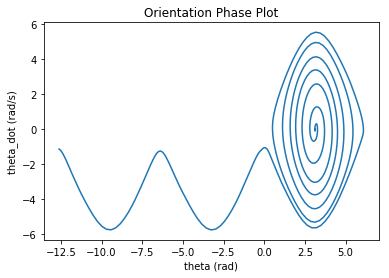

In [12]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")
plt.show()

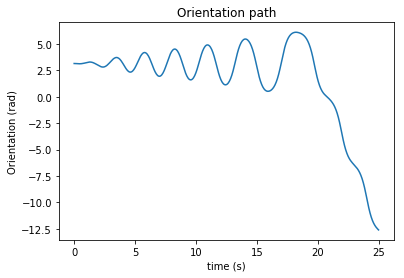

In [13]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

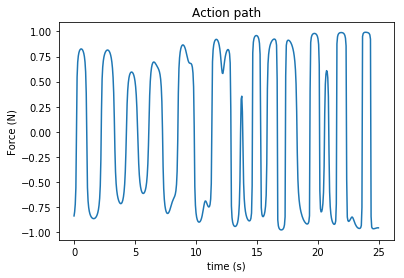

In [14]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

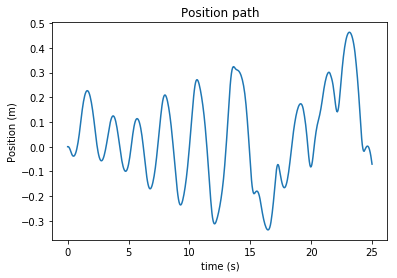

In [15]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

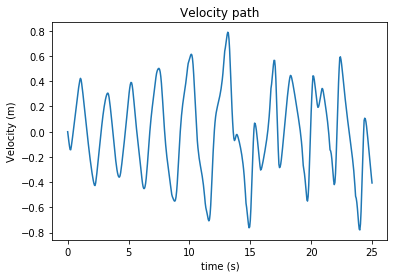

In [16]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

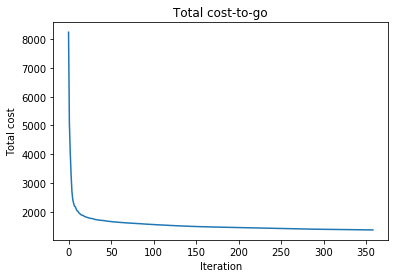

In [17]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")

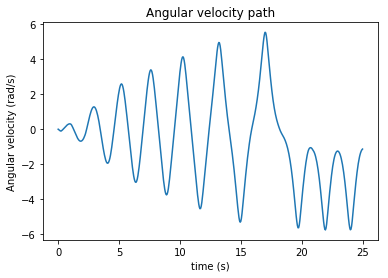

In [18]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

In [ ]:
env.render()
